# Classification

In this notebook we demonstrate how to perform inference for Gaussian process models
with non-Gaussian likelihoods via maximum a posteriori (MAP) and Markov chain Monte
Carlo (MCMC). We focus on a classification task here and use
[BlackJax](https://github.com/blackjax-devs/blackjax/) for sampling.

In [1]:
# Enable Float64 for more stable matrix inversions.
from jax.config import config

config.update("jax_enable_x64", True)

from time import time
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import jax.tree_util as jtu
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
import matplotlib.pyplot as plt
import optax as ox
import tensorflow_probability.substrates.jax as tfp
from tqdm import trange

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

tfd = tfp.distributions
identity_matrix = jnp.eye
key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Dataset

With the necessary modules imported, we simulate a dataset
$\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{100}$ with inputs
$\boldsymbol{x}$ sampled uniformly on $(-1., 1)$ and corresponding binary outputs

$$\boldsymbol{y} = 0.5 * \text{sign}(\cos(2 *  + \boldsymbol{\epsilon})) + 0.5, \quad \boldsymbol{\epsilon} \sim \mathcal{N} \left(\textbf{0}, \textbf{I} * (0.05)^{2} \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs for
later.

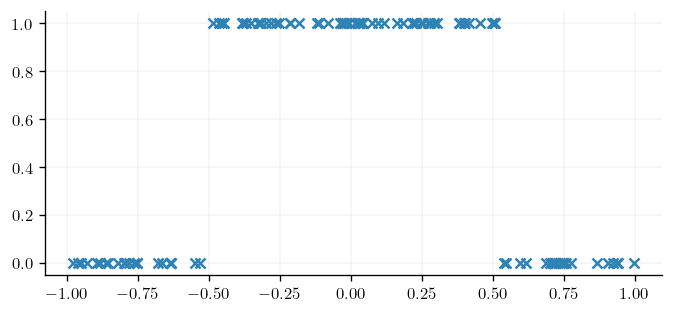

In [2]:
key, subkey = jr.split(key)
x = jr.uniform(key, shape=(100, 1), minval=-1.0, maxval=1.0)
y = 0.5 * jnp.sign(jnp.cos(3 * x + jr.normal(subkey, shape=x.shape) * 0.05)) + 0.5

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-1.0, 1.0, 500).reshape(-1, 1)

fig, ax = plt.subplots()
ax.scatter(x, y)

## MAP inference

We begin by defining a Gaussian process prior with a radial basis function (RBF)
kernel, chosen for the purpose of exposition. Since our observations are binary, we
choose a Bernoulli likelihood with a probit link function.

In [3]:
kernel = gpx.RBF()
meanf = gpx.Constant()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Bernoulli(num_datapoints=D.n)

We construct the posterior through the product of our prior and likelihood.

In [4]:
posterior = prior * likelihood
print(type(posterior))

<class 'gpjax.gps.NonConjugatePosterior'>


Whilst the latent function is Gaussian, the posterior distribution is non-Gaussian
since our generative model first samples the latent GP and propagates these samples
through the likelihood function's inverse link function. This step prevents us from
being able to analytically integrate the latent function's values out of our
posterior, and we must instead adopt alternative inference techniques. We begin with
maximum a posteriori (MAP) estimation, a fast inference procedure to obtain point
estimates for the latent function and the kernel's hyperparameters by maximising the
marginal log-likelihood.

We can obtain a MAP estimate by optimising the log-posterior density with
Optax's optimisers.

In [5]:
negative_lpd = jax.jit(gpx.LogPosteriorDensity(negative=True))

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_lpd,
    train_data=D,
    optim=ox.adamw(learning_rate=0.1),
    num_iters=1000,
    key=key,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

From which we can make predictions at novel inputs, as illustrated below.

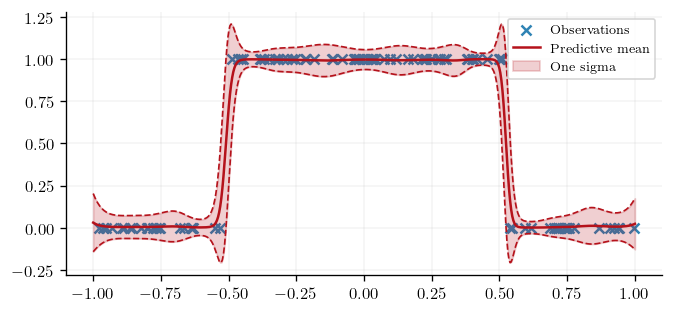

In [6]:
map_latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(map_latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots()
ax.scatter(x, y, label="Observations", color=cols[0])
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color=cols[1],
    label="One sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=1,
)

ax.legend()

Here we projected the map estimates $\hat{\boldsymbol{f}}$ for the function values
$\boldsymbol{f}$ at the data points $\boldsymbol{x}$ to get predictions over the
whole domain,

\begin{align}
p(f(\cdot)| \mathcal{D})  \approx q_{map}(f(\cdot)) := \int p(f(\cdot)| \boldsymbol{f}) \delta(\boldsymbol{f} - \hat{\boldsymbol{f}}) d \boldsymbol{f} = \mathcal{N}(\mathbf{K}_{\boldsymbol{(\cdot)x}}  \mathbf{K}_{\boldsymbol{xx}}^{-1} \hat{\boldsymbol{f}},  \mathbf{K}_{\boldsymbol{(\cdot, \cdot)}} - \mathbf{K}_{\boldsymbol{(\cdot)\boldsymbol{x}}} \mathbf{K}_{\boldsymbol{xx}}^{-1} \mathbf{K}_{\boldsymbol{\boldsymbol{x}(\cdot)}}).
\end{align}

However, as a point estimate, MAP estimation is severely limited for uncertainty
quantification, providing only a single piece of information about the posterior.

## Laplace approximation
The Laplace approximation improves uncertainty quantification by incorporating
curvature induced by the marginal log-likelihood's Hessian to construct an
approximate Gaussian distribution centered on the MAP estimate. Writing
$\tilde{p}(\boldsymbol{f}|\mathcal{D}) = p(\boldsymbol{y}|\boldsymbol{f}) p(\boldsymbol{f})$
as the unormalised posterior for function values $\boldsymbol{f}$ at the datapoints
$\boldsymbol{x}$, we can expand the log of this about the posterior mode
$\hat{\boldsymbol{f}}$ via a Taylor expansion. This gives:

\begin{align}
\log\tilde{p}(\boldsymbol{f}|\mathcal{D}) = \log\tilde{p}(\hat{\boldsymbol{f}}|\mathcal{D}) + \left[\nabla \log\tilde{p}({\boldsymbol{f}}|\mathcal{D})|_{\hat{\boldsymbol{f}}}\right]^{T} (\boldsymbol{f}-\hat{\boldsymbol{f}}) + \frac{1}{2} (\boldsymbol{f}-\hat{\boldsymbol{f}})^{T} \left[\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} \right] (\boldsymbol{f}-\hat{\boldsymbol{f}}) + \mathcal{O}(\lVert \boldsymbol{f} - \hat{\boldsymbol{f}} \rVert^3).
\end{align}

Since $\nabla \log\tilde{p}({\boldsymbol{f}}|\mathcal{D})$ is zero at the mode,
this suggests the following approximation
\begin{align}
\tilde{p}(\boldsymbol{f}|\mathcal{D}) \approx \log\tilde{p}(\hat{\boldsymbol{f}}|\mathcal{D}) \exp\left\{ \frac{1}{2} (\boldsymbol{f}-\hat{\boldsymbol{f}})^{T} \left[-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} \right] (\boldsymbol{f}-\hat{\boldsymbol{f}}) \right\}
\end{align},

that we identify as a Gaussian distribution,
$p(\boldsymbol{f}| \mathcal{D}) \approx q(\boldsymbol{f}) := \mathcal{N}(\hat{\boldsymbol{f}}, [-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} ]^{-1} )$.
Since the negative Hessian is positive definite, we can use the Cholesky
decomposition to obtain the covariance matrix of the Laplace approximation at the
datapoints below.

In [7]:
import cola
from gpjax.lower_cholesky import lower_cholesky

gram, cross_covariance = (kernel.gram, kernel.cross_covariance)
jitter = 1e-6

# Compute (latent) function value map estimates at training points:
Kxx = opt_posterior.prior.kernel.gram(x)
Kxx += identity_matrix(D.n) * jitter
Kxx = cola.PSD(Kxx)
Lx = lower_cholesky(Kxx)
f_hat = Lx @ opt_posterior.latent

# Negative Hessian,  H = -∇²p_tilde(y|f):
H = jax.jacfwd(jax.jacrev(negative_lpd))(opt_posterior, D).latent.latent[:, 0, :, 0]

L = jnp.linalg.cholesky(H + identity_matrix(D.n) * jitter)

# H⁻¹ = H⁻¹ I = (LLᵀ)⁻¹ I = L⁻ᵀL⁻¹ I
L_inv = jsp.linalg.solve_triangular(L, identity_matrix(D.n), lower=True)
H_inv = jsp.linalg.solve_triangular(L.T, L_inv, lower=False)
LH = jnp.linalg.cholesky(H_inv)
laplace_approximation = tfd.MultivariateNormalTriL(f_hat.squeeze(), LH)

For novel inputs, we must project the above approximating distribution through the
Gaussian conditional distribution $p(f(\cdot)| \boldsymbol{f})$,

\begin{align}
p(f(\cdot)| \mathcal{D}) \approx q_{Laplace}(f(\cdot)) := \int p(f(\cdot)| \boldsymbol{f}) q(\boldsymbol{f}) d \boldsymbol{f} = \mathcal{N}(\mathbf{K}_{\boldsymbol{(\cdot)x}}  \mathbf{K}_{\boldsymbol{xx}}^{-1} \hat{\boldsymbol{f}},  \mathbf{K}_{\boldsymbol{(\cdot, \cdot)}} - \mathbf{K}_{\boldsymbol{(\cdot)\boldsymbol{x}}} \mathbf{K}_{\boldsymbol{xx}}^{-1} (\mathbf{K}_{\boldsymbol{xx}} - [-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} ]^{-1}) \mathbf{K}_{\boldsymbol{xx}}^{-1} \mathbf{K}_{\boldsymbol{\boldsymbol{x}(\cdot)}}).
\end{align}

This is the same approximate distribution $q_{map}(f(\cdot))$, but we have perturbed
the covariance by a curvature term of
$\mathbf{K}_{\boldsymbol{(\cdot)\boldsymbol{x}}} \mathbf{K}_{\boldsymbol{xx}}^{-1} [-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} ]^{-1} \mathbf{K}_{\boldsymbol{xx}}^{-1} \mathbf{K}_{\boldsymbol{\boldsymbol{x}(\cdot)}}$.
We take the latent distribution computed in the previous section and add this term
to the covariance to construct $q_{Laplace}(f(\cdot))$.

In [8]:
def construct_laplace(test_inputs: Float[Array, "N D"]) -> tfd.MultivariateNormalTriL:
    map_latent_dist = opt_posterior.predict(xtest, train_data=D)

    Kxt = opt_posterior.prior.kernel.cross_covariance(x, test_inputs)
    Kxx = opt_posterior.prior.kernel.gram(x)
    Kxx += identity_matrix(D.n) * jitter
    Kxx = cola.PSD(Kxx)

    # Kxx⁻¹ Kxt
    Kxx_inv_Kxt = cola.solve(Kxx, Kxt)

    # Ktx Kxx⁻¹[ H⁻¹ ] Kxx⁻¹ Kxt
    laplace_cov_term = jnp.matmul(jnp.matmul(Kxx_inv_Kxt.T, H_inv), Kxx_inv_Kxt)

    mean = map_latent_dist.mean()
    covariance = map_latent_dist.covariance() + laplace_cov_term
    L = jnp.linalg.cholesky(covariance)
    return tfd.MultivariateNormalTriL(jnp.atleast_1d(mean.squeeze()), L)

From this we can construct the predictive distribution at the test points.

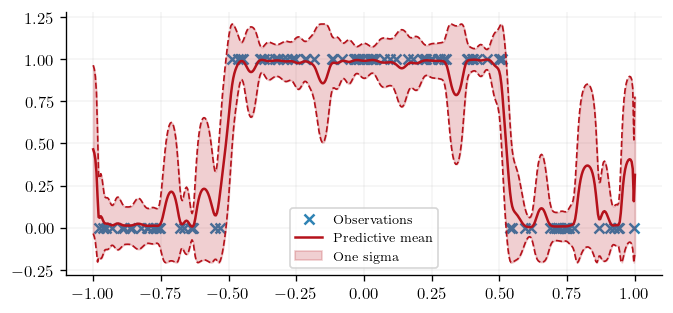

In [9]:
laplace_latent_dist = construct_laplace(xtest)
predictive_dist = opt_posterior.likelihood(laplace_latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots()
ax.scatter(x, y, label="Observations", color=cols[0])
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color=cols[1],
    label="One sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.legend()

However, the Laplace approximation is still limited by considering information about
the posterior at a single location. On the other hand, through approximate sampling,
MCMC methods allow us to learn all information about the posterior distribution.

## MCMC inference

An MCMC sampler works by starting at an initial position and
drawing a sample from a cheap-to-simulate distribution known as the _proposal_. The
next step is to determine whether this sample could be considered a draw from the
posterior. We accomplish this using an _acceptance probability_ determined via the
sampler's _transition kernel_ which depends on the current position and the
unnormalised target posterior distribution. If the new sample is more _likely_, we
accept it; otherwise, we reject it and stay in our current position. Repeating these
steps results in a Markov chain (a random sequence that depends only on the last
state) whose stationary distribution (the long-run empirical distribution of the
states visited) is the posterior. For a gentle introduction, see the first chapter
of [A Handbook of Markov Chain Monte Carlo](https://www.mcmchandbook.net/HandbookChapter1.pdf).

### MCMC through BlackJax

Rather than implementing a suite of MCMC samplers, GPJax relies on MCMC-specific
libraries for sampling functionality. We focus on
[BlackJax](https://github.com/blackjax-devs/blackjax/) in this notebook, which we
recommend adopting for general applications.

We'll use the No U-Turn Sampler (NUTS) implementation given in BlackJax for sampling.
For the interested reader, NUTS is a Hamiltonian Monte Carlo sampling scheme where
the number of leapfrog integration steps is computed at each step of the change
according to the NUTS algorithm. In general, samplers constructed under this
framework are very efficient.

We begin by generating _sensible_ initial positions for our sampler before defining
an inference loop and sampling 500 values from our Markov chain. In practice,
drawing more samples will be necessary.

In [10]:
num_adapt = 500
num_samples = 500

lpd = jax.jit(gpx.LogPosteriorDensity(negative=False))
unconstrained_lpd = jax.jit(lambda tree: lpd(tree.constrain(), D))

adapt = blackjax.window_adaptation(
    blackjax.nuts, unconstrained_lpd, num_adapt, target_acceptance_rate=0.65
)

# Initialise the chain
start = time()
last_state, kernel, _ = adapt.run(key, posterior.unconstrain())
print(f"Adaption time taken: {time() - start: .1f} seconds")


def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos


# Sample from the posterior distribution
start = time()
states, infos = inference_loop(key, kernel, last_state, num_samples)
print(f"Sampling time taken: {time() - start: .1f} seconds")

### Sampler efficiency

BlackJax gives us easy access to our sampler's efficiency through metrics such as the
sampler's _acceptance probability_ (the number of times that our chain accepted a
proposed sample, divided by the total number of steps run by the chain). For NUTS and
Hamiltonian Monte Carlo sampling, we typically seek an acceptance rate of 60-70% to
strike the right balance between having a chain which is _stuck_ and rarely moves
versus a chain that is too jumpy with frequent small steps.

In [ ]:
acceptance_rate = jnp.mean(infos.acceptance_probability)
print(f"Acceptance rate: {acceptance_rate:.2f}")

Our acceptance rate is slightly too large, prompting an examination of the chain's
trace plots. A well-mixing chain will have very few (if any) flat spots in its trace
plot whilst also not having too many steps in the same direction. In addition to
the model's hyperparameters, there will be 500 samples for each of the 100 latent
function values in the `states.position` dictionary. We depict the chains that
correspond to the model hyperparameters and the first value of the latent function
for brevity.

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(10, 3))
ax0.plot(states.position.prior.kernel.lengthscale)
ax1.plot(states.position.prior.kernel.variance)
ax2.plot(states.position.latent[:, 1, :])
ax0.set_title("Kernel Lengthscale")
ax1.set_title("Kernel Variance")
ax2.set_title("Latent Function (index = 1)")

## Prediction

Having obtained samples from the posterior, we draw ten instances from our model's
predictive distribution per MCMC sample. Using these draws, we will be able to
compute credible values and expected values under our posterior distribution.

An ideal Markov chain would have samples completely uncorrelated with their
neighbours after a single lag. However, in practice, correlations often exist
within our chain's sample set. A commonly used technique to try and reduce this
correlation is _thinning_ whereby we select every $n$th sample where $n$ is the
minimum lag length at which we believe the samples are uncorrelated. Although further
analysis of the chain's autocorrelation is required to find appropriate thinning
factors, we employ a thin factor of 10 for demonstration purposes.

In [ ]:
thin_factor = 20
posterior_samples = []

for i in trange(0, num_samples, thin_factor, desc="Drawing posterior samples"):
    sample = jtu.tree_map(lambda samples, i=i: samples[i], states.position)
    sample = sample.constrain()
    latent_dist = sample.predict(xtest, train_data=D)
    predictive_dist = sample.likelihood(latent_dist)
    posterior_samples.append(predictive_dist.sample(seed=key, sample_shape=(10,)))

posterior_samples = jnp.vstack(posterior_samples)
lower_ci, upper_ci = jnp.percentile(posterior_samples, jnp.array([2.5, 97.5]), axis=0)
expected_val = jnp.mean(posterior_samples, axis=0)


Finally, we end this tutorial by plotting the predictions obtained from our model
against the observed data.

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y, color=cols[0], label="Observations", zorder=2, alpha=0.7)
ax.plot(xtest, expected_val, color=cols[1], label="Predicted mean", zorder=1)
ax.fill_between(
    xtest.flatten(),
    lower_ci.flatten(),
    upper_ci.flatten(),
    alpha=0.2,
    color=cols[1],
    label="95\\% CI",
)
ax.plot(
    xtest,
    lower_ci.flatten(),
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    upper_ci.flatten(),
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.legend()

## System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder & Daniel Dodd"